In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.dates as mdates

# load data
air_quality = pd.read_json("data/air_quality/2021_Melbourne_CBD_air_quality.json")
health_data = pd.read_json("data/asthma_copd/asthma_copd_merged.json")
sa2_mapping = pd.read_csv('data/Melbourne_Inner_SA2.csv')

print(air_quality.head())
print(health_data.head())


         datetime_AEST       datetime_local  location_id  location_name  \
0  2020-12-31 23:00:00  2021-01-01 00:00:00        10239  Melbourne CBD   
1  2021-01-01 00:00:00  2021-01-01 01:00:00        10239  Melbourne CBD   
2  2021-01-01 01:00:00  2021-01-01 02:00:00        10239  Melbourne CBD   
3  2021-01-01 02:00:00  2021-01-01 03:00:00        10239  Melbourne CBD   
4  2021-01-01 03:00:00  2021-01-01 04:00:00        10239  Melbourne CBD   

   BPM2.5  
0   0.400  
1   5.750  
2  -3.867  
3   5.100  
4   5.350  
   cob_aus_lc_copd_emph  cob_aus_asth  sa2_code_2021
0                     9           328      206041504
1                    75           885      206041506
2                     0             6      206041120
3                    79           801      206041121
4                    22           460      206041505


Total missing days in PM2.5 data: 9


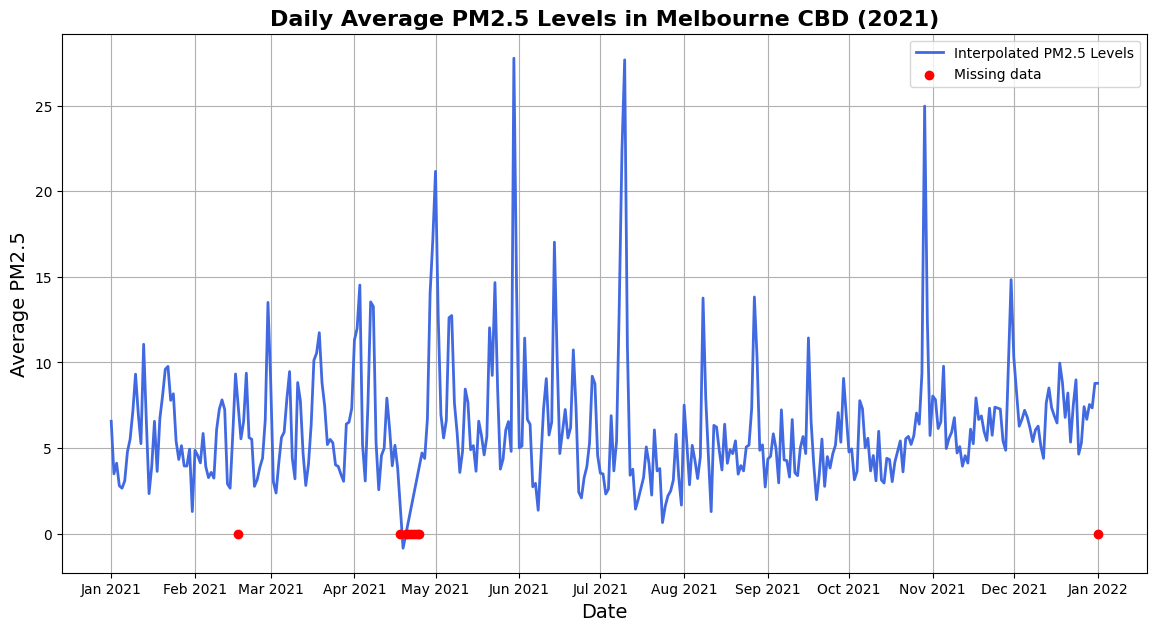

In [20]:
# Convert 'datetime_local' column to datetime and set it as index
air_quality['datetime_local'] = pd.to_datetime(air_quality['datetime_local'])
air_quality.set_index('datetime_local', inplace=True)

# Calculate daily average PM2.5 levels
daily_pm25 = air_quality['BPM2.5'].resample('D').mean()

# Check for missing data and interpolate if necessary
missing_data_count = daily_pm25.isnull().sum()
print(f"Total missing days in PM2.5 data: {missing_data_count}")

# Interpolating missing data using linear interpolation
daily_pm25_interpolated = daily_pm25.interpolate()

# Create a plot with improved aesthetics
plt.figure(figsize=(14, 7))
plt.plot(daily_pm25_interpolated.index, daily_pm25_interpolated, label='Interpolated PM2.5 Levels', color='royalblue', linewidth=2)

# Highlighting missing data points before interpolation
missing_data_points = daily_pm25[daily_pm25.isnull()]
plt.scatter(missing_data_points.index, [0]*len(missing_data_points), color='red', label='Missing data', zorder=5)

# Adding title and labels with additional styling
plt.title('Daily Average PM2.5 Levels in Melbourne CBD (2021)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average PM2.5', fontsize=14)

# Improve the x-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add a legend to the plot
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()

0    POLYGON ((149.58424 -35.44426, 149.58444 -35.4...
1    POLYGON ((149.21899 -35.36738, 149.21800 -35.3...
2    POLYGON ((149.21326 -35.34325, 149.21619 -35.3...
3    POLYGON ((149.24034 -35.34781, 149.24024 -35.3...
4    POLYGON ((149.19572 -35.36126, 149.19970 -35.3...
Name: geometry, dtype: geometry


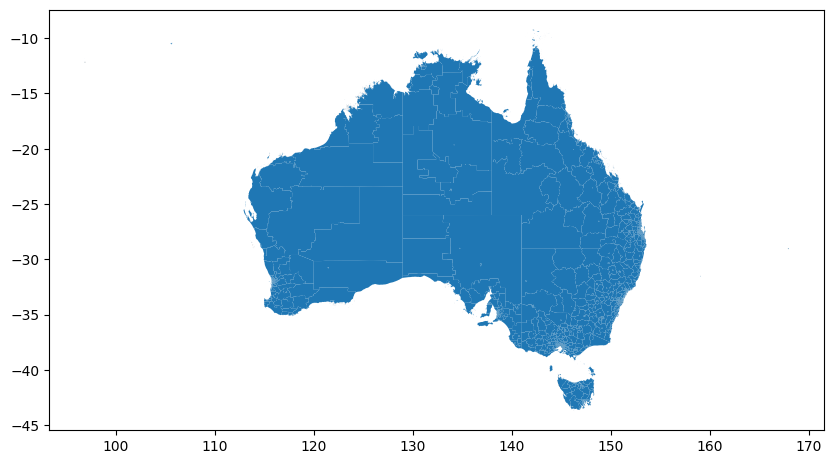

In [3]:
# Load the geographical data for Melbourne Inner SA2
gdf = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp').to_crs(epsg=4326)

# Check the geometry
print(gdf.geometry.head())

# Attempt a simple plot of the geographical data to check for any issues
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax)
plt.show()



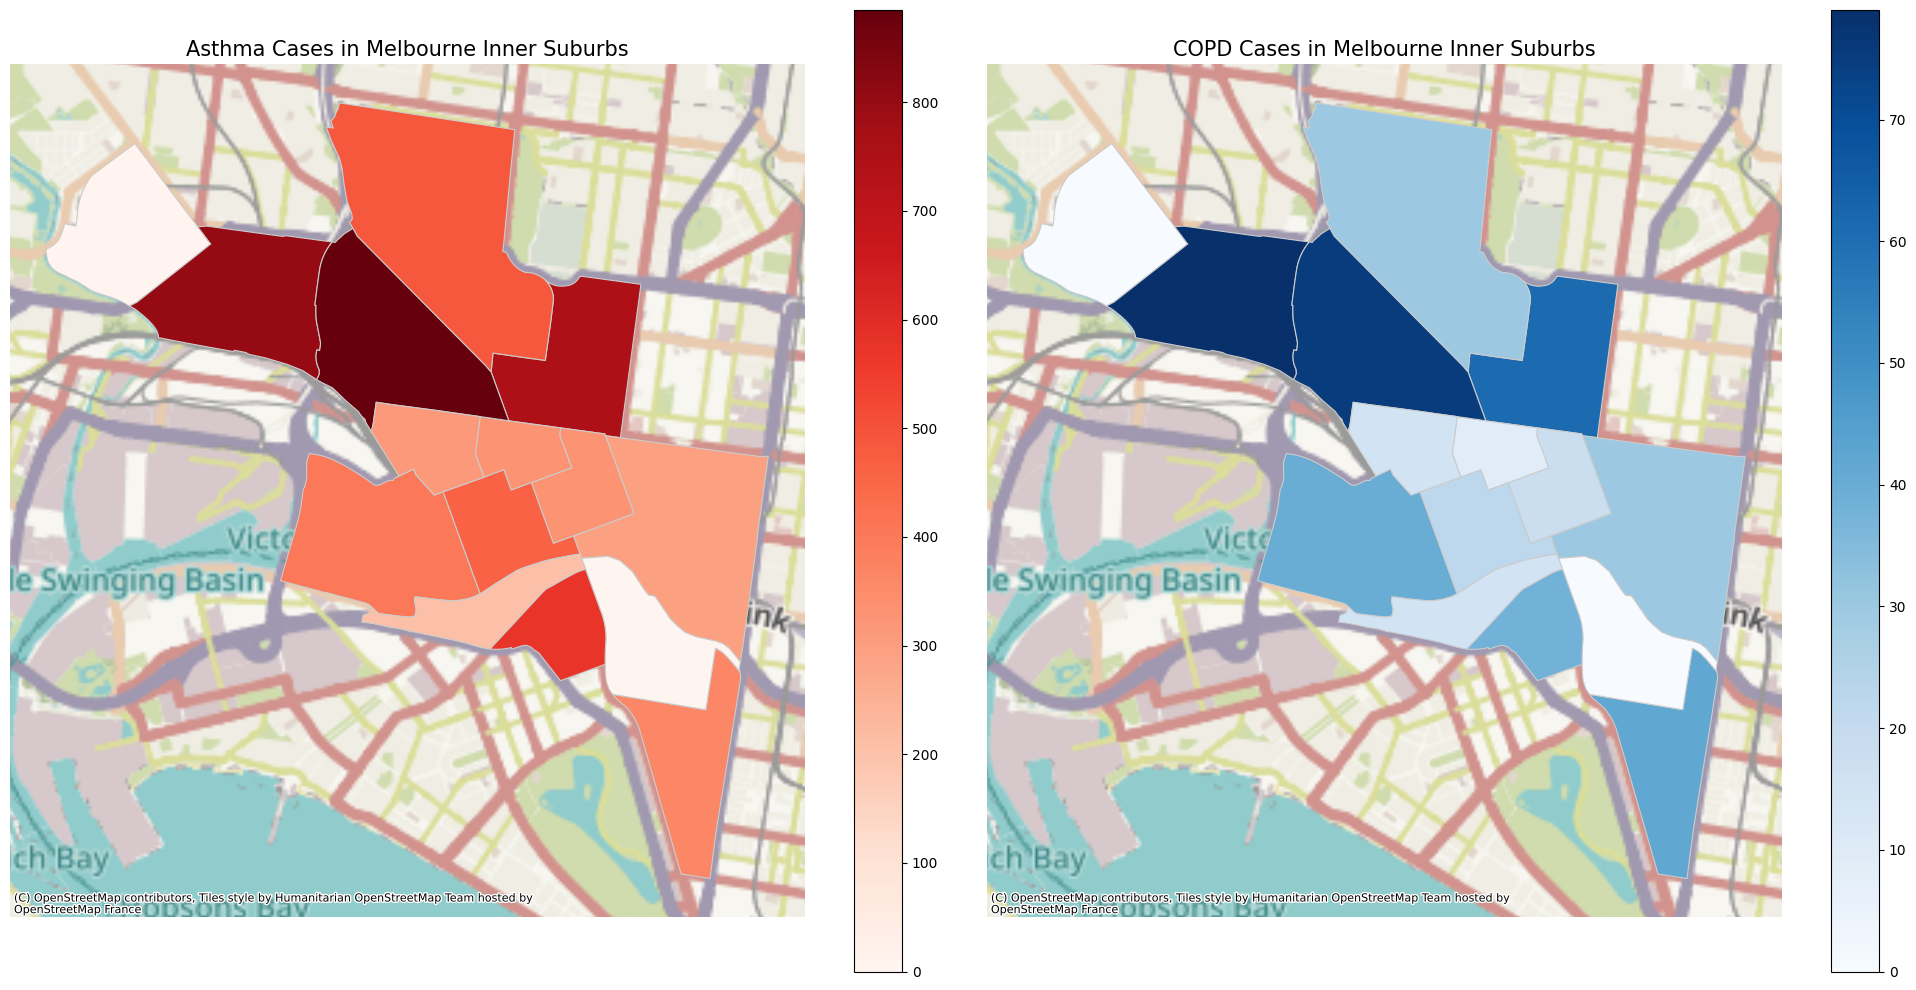

In [4]:
# Convert codes to string to ensure data type consistency
gdf['SA2_CODE21'] = gdf['SA2_CODE21'].astype(str)
health_data['sa2_code_2021'] = health_data['sa2_code_2021'].astype(str)
sa2_mapping['SA2_CODE_2021'] = sa2_mapping['SA2_CODE_2021'].astype(str)

# Filter for Melbourne's inner suburbs
gdf_inner = gdf[gdf['SA2_NAME21'].isin(sa2_mapping['SA2_NAME_2021'])]

# Merge health data with geographic data
merged_data = gdf_inner.merge(health_data, how='left', left_on='SA2_CODE21', right_on='sa2_code_2021')

# Convert coordinates system to Web Mercator for mapping
merged_data = merged_data.to_crs(epsg=3857)

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# Map for asthma cases using a red color map
merged_data.plot(column='cob_aus_asth', cmap='Reds', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Asthma Cases in Melbourne Inner Suburbs', fontsize=15)
ax1.set_axis_off()
ctx.add_basemap(ax1, zoom=12)  # Add a basemap for context

# Map for COPD cases using a blue color map
merged_data.plot(column='cob_aus_lc_copd_emph', cmap='Blues', linewidth=0.8, ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title('COPD Cases in Melbourne Inner Suburbs', fontsize=15)
ax2.set_axis_off()
ctx.add_basemap(ax2, zoom=12)  # Add a basemap for context

plt.tight_layout()  # Adjust subplots layout to ensure consistent spacing
plt.show()